In [132]:
SEED = 101
N_GRAM = 3
VAL_FRAC = 0.1
D = 2
VOCAB = 27
H = 96
B = 8192
E = 100

In [44]:
import torch

ctoi = lambda c: ord(c) - 96 if c != "." else 0
itoc = lambda i: chr(i + 96) if i != 0 else "."

words = []

xs = []
ys = []
x = []
y = []
with open("names.txt", "r") as f:
    for line in f.read().splitlines():
        words.append(line)
        line = "." * N_GRAM + line + "."
        for i, c in enumerate(line[N_GRAM:]):
            xi = line[i: i + N_GRAM]
            yi = c
            xs.append(xi)
            ys.append(yi)
            x.append([ctoi(xc) for xc in xi])
            y.append(ctoi(yi))
            
for i in range(5):
    print(xs[i], ": ", ys[i])

val = int(len(x) * VAL_FRAC)

x = torch.tensor(x)
y = torch.tensor(y)
x_train = x[val:]
y_train = y[val:]
x_val = x[:val]
y_val = y[:val]

... :  e
..e :  m
.em :  m
emm :  a
mma :  .


In [93]:
import torch.nn.functional as F

C = torch.rand(VOCAB, D)

R1 = F.one_hot(x, VOCAB).float() @ C
print(R1.shape)
print(R1[0])


torch.Size([228146, 3, 2])
tensor([[0.5118, 0.0306],
        [0.5118, 0.0306],
        [0.5118, 0.0306]])


In [91]:
# Demo cat and view is the same

W1 = torch.rand(6, 4)

cat_r1 = torch.cat([R1[:, 0, :], R1[:, 1, :], R1[:, 2, :]], dim=1)
print("cat_r1 shape: ", cat_r1.shape)

cat_r2 = cat_r1 @ W1
print("cat_r2 shape: ", cat_r2.shape)

r2 = R1.view(-1, 6) @ W1
print("r2 shape: ", r2.shape)

print("cat_r2[0], ", cat_r2[0])
print("r2[0]", r2[0])


cat_r1 shape:  torch.Size([228146, 6])
cat_r2 shape:  torch.Size([228146, 4])
r2 shape:  torch.Size([228146, 4])
cat_r2[0],  tensor([0.9202, 0.5120, 1.5822, 1.3287])
r2[0] tensor([0.9202, 0.5120, 1.5822, 1.3287])


In [98]:
W1 = torch.rand(D * N_GRAM, H)
B1 = torch.rand(H)

R2 = torch.tanh(R1.view(-1, 6) @ W1 + B1)
R2.shape

torch.Size([228146, 96])

In [107]:
import torch.nn.functional as F
W2 = torch.rand(H, VOCAB)
B2 = torch.rand(VOCAB)

R = F.softmax(R2 @ W2 + B2, dim=-1)
R.shape

torch.Size([228146, 27])

In [172]:
# Training

g = torch.Generator().manual_seed(SEED)
C = torch.rand(VOCAB, D, generator=g, requires_grad=True)
W1 = torch.rand(D * N_GRAM, H, generator=g, requires_grad=True)
B1 = torch.rand(H, generator=g, requires_grad=True)
W2 = torch.rand(H, VOCAB, generator=g, requires_grad=True)
B2 = torch.rand(VOCAB, generator=g, requires_grad=True)

params = [C, W1, B1, W2, B2]
# for p in params:
#     p.requires_grad = True

In [173]:
losses = []

for e in range(1, E + 1):
    R1 = F.one_hot(x_train, VOCAB).float() @ C
    R2 = torch.tanh(R1.view(-1, N_GRAM * D) @ W1 + B1)
    R = R2 @ W2 + B2
    loss = F.cross_entropy(R, y_train)
    loss.backward()

    # for p in params:
    #     p.data += -10 * p.grad

    with torch.no_grad():
        for p in params:
            p += -1 * p.grad

    for p in params:
        p.grad = None
    print(f"E {e}. Loss: {loss}")
    losses.append(torch.log10(loss).item())


E 1. Loss: 5.557264804840088
E 2. Loss: 8.23434829711914
E 3. Loss: 17.946279525756836
E 4. Loss: 9.529510498046875
E 5. Loss: 6.250507831573486
E 6. Loss: 6.115035057067871
E 7. Loss: 4.457155227661133
E 8. Loss: 3.37924861907959
E 9. Loss: 3.187769889831543
E 10. Loss: 3.419564723968506
E 11. Loss: 3.048677921295166
E 12. Loss: 2.973933458328247
E 13. Loss: 2.8263494968414307
E 14. Loss: 2.801356554031372
E 15. Loss: 2.7518484592437744
E 16. Loss: 2.750157594680786
E 17. Loss: 2.711944818496704
E 18. Loss: 2.7235605716705322
E 19. Loss: 2.687786340713501
E 20. Loss: 2.699688196182251
E 21. Loss: 2.670769453048706
E 22. Loss: 2.6792423725128174
E 23. Loss: 2.658043384552002
E 24. Loss: 2.665506601333618
E 25. Loss: 2.64827299118042
E 26. Loss: 2.6563546657562256
E 27. Loss: 2.639498710632324
E 28. Loss: 2.6477363109588623
E 29. Loss: 2.6303110122680664
E 30. Loss: 2.6375725269317627
E 31. Loss: 2.6209654808044434
E 32. Loss: 2.626990795135498
E 33. Loss: 2.6122195720672607
E 34. Loss:

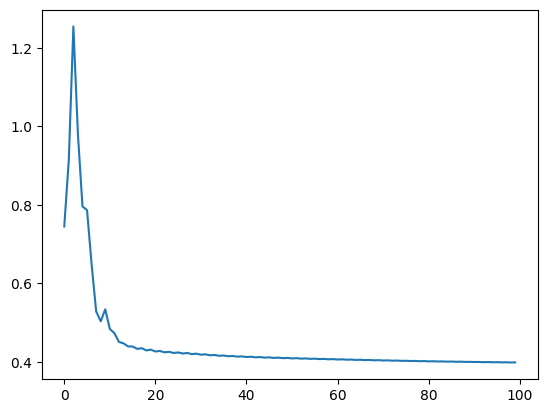

In [174]:
import matplotlib.pyplot as plt
plt.plot(range(E), losses)

In [167]:
# minibatch

for e in range(1, 10 + 1):
    for b in range(B, len(x_train), B):
        R1 = F.one_hot(x_train[b - B: b], VOCAB).float() @ C
        R2 = torch.tanh(R1.view(-1, N_GRAM * D) @ W1 + B1)
        R = R2 @ W2 + B2
        loss = F.cross_entropy(R, y_train[b - B: b])
        loss.backward()
    
        for p in params:
            p.data += -0.1 * p.grad
    
        for p in params:
            p.grad = None
        print(f"E {e}. Loss: {loss}")

E 1. Loss: 2.6889748573303223
E 1. Loss: 2.6768972873687744
E 1. Loss: 2.6793200969696045
E 1. Loss: 2.6672780513763428
E 1. Loss: 2.676612615585327
E 1. Loss: 2.6767661571502686
E 1. Loss: 2.684404134750366
E 1. Loss: 2.6924309730529785
E 1. Loss: 2.6696629524230957
E 1. Loss: 2.694227695465088
E 1. Loss: 2.7063217163085938
E 1. Loss: 2.6704630851745605
E 1. Loss: 2.6984076499938965
E 1. Loss: 2.8489599227905273
E 1. Loss: 2.8156964778900146
E 1. Loss: 2.786959409713745
E 1. Loss: 2.8154678344726562
E 1. Loss: 2.8067967891693115
E 1. Loss: 2.8173911571502686
E 1. Loss: 2.80387806892395
E 1. Loss: 2.8082151412963867
E 1. Loss: 2.8191885948181152
E 1. Loss: 2.7905499935150146
E 1. Loss: 2.832927703857422
E 1. Loss: 2.806173086166382
E 2. Loss: 2.701183795928955
E 2. Loss: 2.6696956157684326
E 2. Loss: 2.666908025741577
E 2. Loss: 2.6510009765625
E 2. Loss: 2.657618284225464
E 2. Loss: 2.6601455211639404
E 2. Loss: 2.66465425491333
E 2. Loss: 2.6748838424682617
E 2. Loss: 2.6500470638275

In [175]:
# train loss vs val_loss
R1 = F.one_hot(x_train, VOCAB).float() @ C
R2 = torch.tanh(R1.view(-1, N_GRAM * D) @ W1 + B1)
R = F.softmax(R2 @ W2 + B2, dim=-1)
loss = F.cross_entropy(R, y_train)
print(loss.item())

R1 = F.one_hot(x_val, VOCAB).float() @ C
R2 = torch.tanh(R1.view(-1, N_GRAM * D) @ W1 + B1)
R = F.softmax(R2 @ W2 + B2, dim=-1)
loss = F.cross_entropy(R, y_val)
print(loss.item())

3.197472333908081
3.1918349266052246


In [176]:
R1 = F.one_hot(x_val, VOCAB).float() @ C
R2 = torch.tanh(R1.view(-1, N_GRAM * D) @ W1 + B1)
R = torch.argmax(F.softmax(R2 @ W2 + B2, dim=-1), dim=-1)

print(f"x_val: {x_val[0: 10]}; r: {R[0: 10]}; y_val: {y_val[0: 10]}")


x_val: tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22]]); r: tensor([ 1,  1,  1,  5, 14,  1, 13,  1,  0,  9]); y_val: tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9])


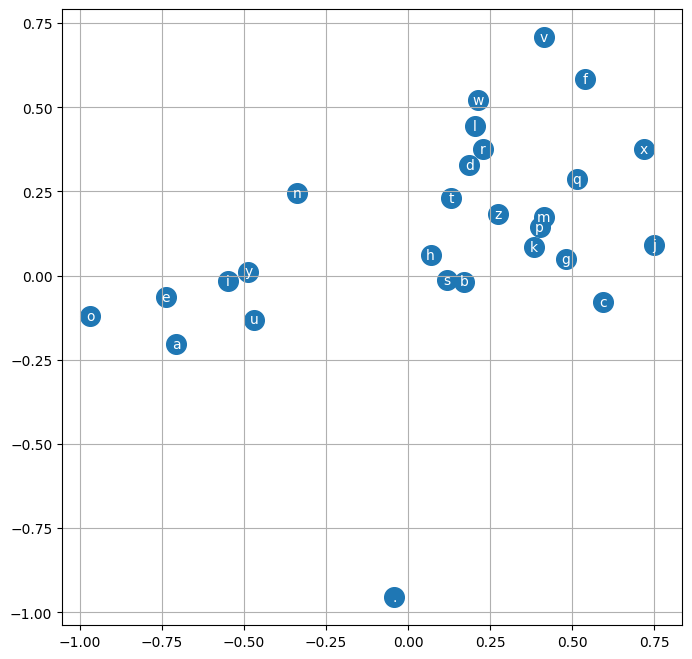

In [179]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc(i), ha="center", va="center", color='white')
plt.grid('minor')

In [220]:
for i in range(20):
    x = x_val[i]
    name = ""
    while True:
        R1 = F.one_hot(x, VOCAB).float() @ C
        R2 = torch.tanh(R1.view(-1, N_GRAM * D) @ W1 + B1)
        R = F.softmax(R2 @ W2 + B2, dim=-1)
        ix = torch.multinomial(R, num_samples=1, generator=g).item()
        name += itoc(ix)
        # x = torch.cat((x[1:], torch.tensor(ix)))
        x = torch.cat((x[1:], torch.tensor([ix])))
        if ix == 0:
            break
    print(name)

yfindakilaroly.
di.
aed.
yiminaca.
yll.
hyg.
echxeedhagemi.
tes.
htoadh.
riyas.
lg.
.
nel.
mie.
as.
sneylod.
dedos.
al.
adhenizenl.
m.


In [83]:
torch.cat([R1[:, 0, :], R1[:, 1, :], R1[:, 2, :]], dim=1).shape

torch.Size([228146, 6])

In [187]:
torch.cat((torch.rand((3, 3))[1, 0:2], torch.rand(1)))

tensor([0.3794, 0.0191, 0.1824])

In [ ]:
torch.